#  这里开始

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Voting 
data = pd.read_csv('第一问所有特征.csv',encoding='gbk',index_col='企业代号')
for i in range(len(data)):
    a='E'+str(i+1)
    if data.loc[a,'是否违约']=='否':
        data.loc[a,'违约']=0
    else :
        data.loc[a,'违约']=1

x = data.iloc[:,:-3].values
y = data.iloc[:,-1].values

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

LR = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
Ada = ada(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
                   n_estimators=100, random_state=30)
GBDT = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.7, loss='exponential', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=25,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=30, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
svc = SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=20, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

rf = RF(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=30, verbose=0,
                       warm_start=False)


sclf = StackingCVClassifier(classifiers=[Ada, GBDT, LR,rf],
                            use_probas=True,
                            meta_classifier=svc,
                            random_state=30)
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=30)

tranfer = StandardScaler()
x = tranfer.fit_transform(x)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)


weight = []
for clf, label in zip([LR, Ada, GBDT, svc, rf, sclf],
                      ['LR',
                       'Ada',
                       'GBDT',
                       'svc',
                       'rf', 'StackingClassifier']):
    clf.fit(x_train, y_train)
    y_predict = clf.predict(x_test)
    print('{}在预测集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_test, y_predict))
    print('{}在训练集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_train, clf.predict(x_train)))
    print('{}的综合准确率为：\n'.format(label), metrics.accuracy_score(y, clf.predict(x)))
    tem = metrics.accuracy_score(y, clf.predict(x))
    weight.append(tem)
    print('{}的ROC面积为：'.format(label), metrics.roc_auc_score(y, clf.predict(x)))
    print()

weight
del weight[-1]

# 软投票
w = weight/sum(weight)

vote2= VotingClassifier(estimators=[('LR',LR),('Ada',Ada), ('GBDT',GBDT), ('SVC',svc),('rf',rf)],
                          voting='soft',weights=weight)
vote2.fit(x_train,y_train)
y_predict = vote2.predict(x_test)
print('{}在预测集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_test,y_predict))
print('{}在训练集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_train,vote2.predict(x_train)))
print('soft voting的综合表现:\n',metrics.accuracy_score(y,vote2.predict(x)))
print()
print('soft voting的ROC面积：\n',roc_auc_score(y,vote2.predict(x)))

P = vote2.predict_proba(x)[:,1]
df = pd.DataFrame(data={'违约概率':P})

LR在预测集模型的准确率为：
 0.8387096774193549
LR在训练集模型的准确率为：
 0.9021739130434783
LR的综合准确率为：
 0.8861788617886179
LR的ROC面积为： 0.754050925925926

Ada在预测集模型的准确率为：
 0.9032258064516129
Ada在训练集模型的准确率为：
 0.9130434782608695
Ada的综合准确率为：
 0.9105691056910569
Ada的ROC面积为： 0.8229166666666665

GBDT在预测集模型的准确率为：
 0.8064516129032258
GBDT在训练集模型的准确率为：
 1.0
GBDT的综合准确率为：
 0.9512195121951219
GBDT的ROC面积为： 0.9421296296296298

svc在预测集模型的准确率为：
 0.8709677419354839
svc在训练集模型的准确率为：
 0.9782608695652174
svc的综合准确率为：
 0.9512195121951219
svc的ROC面积为： 0.8888888888888888

rf在预测集模型的准确率为：
 0.8709677419354839
rf在训练集模型的准确率为：
 1.0
rf的综合准确率为：
 0.967479674796748
rf的ROC面积为： 0.9525462962962963

StackingClassifier在预测集模型的准确率为：
 0.8709677419354839
StackingClassifier在训练集模型的准确率为：
 0.9130434782608695
StackingClassifier的综合准确率为：
 0.9024390243902439
StackingClassifier的ROC面积为： 0.791087962962963

soft Voting在预测集模型的准确率为：
 0.9032258064516129
soft Voting在训练集模型的准确率为：
 1.0
soft voting的综合表现:
 0.975609756097561

soft voting的ROC面积：
 0.9577546296296297


In [149]:
P = vote2.predict_proba(x)[:,1]

In [150]:
df['信誉评级'] = data['信誉评级'].reset_index()['信誉评级']

In [151]:
df

,违约概率,信誉评级
0,0.147025,A
1,0.112562,A
2,0.085309,C
3,0.098115,C
4,0.130408,B
...,...,...
118,0.708650,D
119,0.878934,D
120,0.685601,D
121,0.828814,D


In [152]:
aver_A =0

In [153]:
A_aver = sum(df[df['信誉评级']=='A']['违约概率'])/len(df[df['信誉评级']=='A']['违约概率'])
B_aver = sum(df[df['信誉评级']=='B']['违约概率'])/len(df[df['信誉评级']=='B']['违约概率'])
C_aver = sum(df[df['信誉评级']=='C']['违约概率'])/len(df[df['信誉评级']=='C']['违约概率'])
D_aver = sum(df[df['信誉评级']=='D']['违约概率'])/len(df[df['信誉评级']=='D']['违约概率'])

In [154]:
print(A_aver)
print(B_aver)
print(C_aver)
print(D_aver)

0.14426295660833713
0.18129890381437538
0.20859283971389891
0.721983801312892


In [155]:
da = {'A企业违约风险':A_aver,'B企业违约风险':B_aver,'C企业违约风险':C_aver,'D企业违约风险':D_aver}
da1 = pd.DataFrame(data=da,index=[0])
da1

,A企业违约风险,B企业违约风险,C企业违约风险,D企业违约风险
0,0.144263,0.181299,0.208593,0.721984


In [156]:
da1.to_csv('平均违约风险最终结果.csv',encoding='gbk')

# ROC曲线的绘制

In [157]:
# 软投票
vote2= VotingClassifier(estimators=[('LR',LR),('Ada',Ada), ('GBDT',GBDT), ('SVC',svc),('rf',rf)],
                          voting='soft',weights=weight)
vote2.fit(x_train,y_train)
y_predict = vote2.predict(x_test)
print('{}在预测集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_test,y_predict))
print('{}在训练集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_train,vote2.predict(x_train)))
print('soft voting的综合表现:\n',metrics.accuracy_score(y,vote2.predict(x)))
print()
print('soft voting的ROC面积：\n',roc_auc_score(y,vote2.predict(x)))

soft Voting在预测集模型的准确率为：
 0.9032258064516129
soft Voting在训练集模型的准确率为：
 1.0
soft voting的综合表现:
 0.975609756097561

soft voting的ROC面积：
 0.9577546296296297


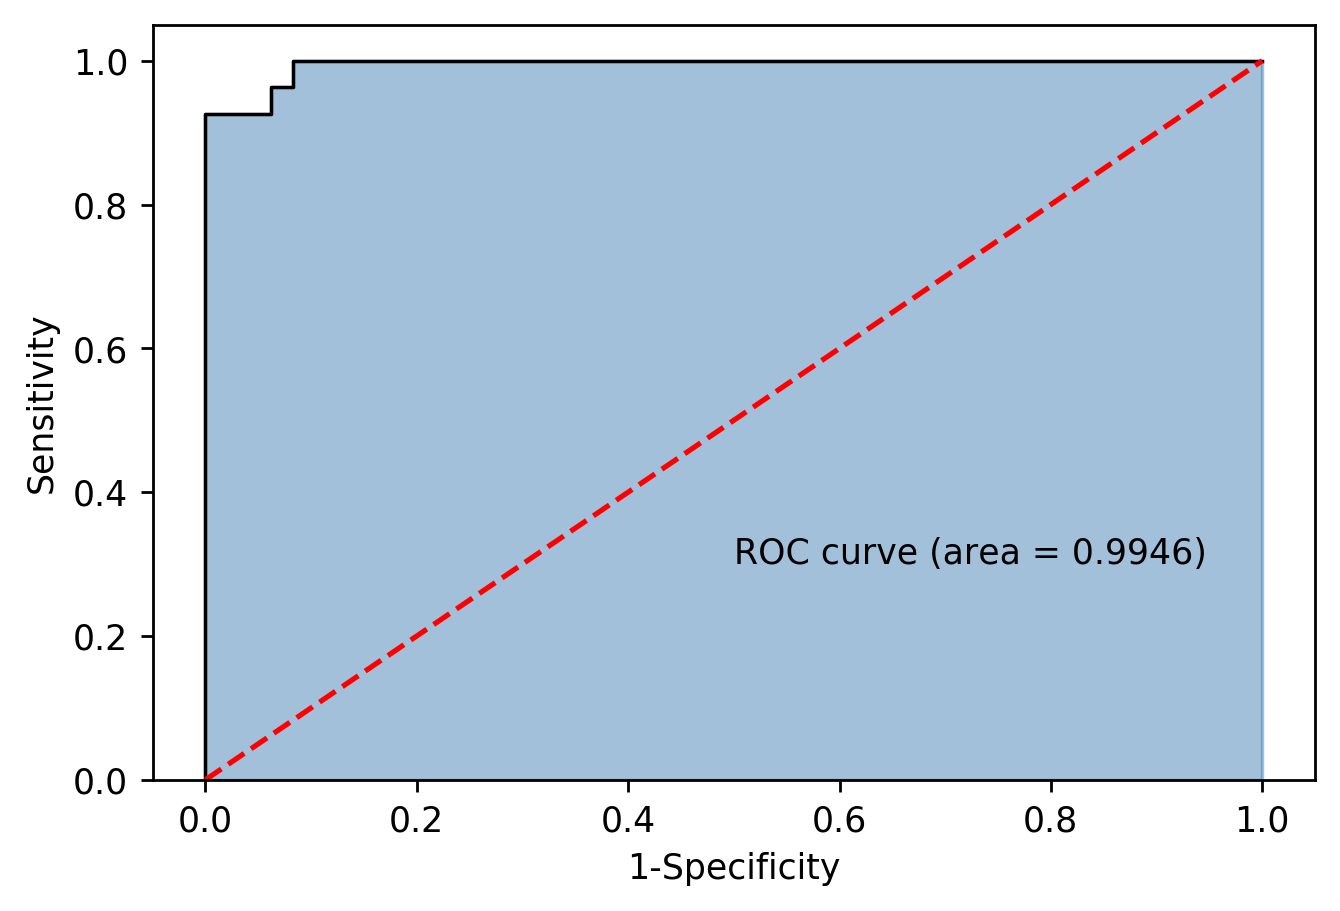

In [158]:
fpr,tpr,threshold = metrics.roc_curve(y,P)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)

#绘制面积图
plt.figure(figsize=(6,4),dpi=250)
plt.stackplot(fpr,tpr,color='steelblue',alpha=0.5,edgecolor='black')
# 添加边际线
plt.plot(fpr,tpr,color='black',lw=1)
# 添加对角线
plt.plot([0,1],[0,1],color='red',linestyle='--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.4f)' % roc_auc,fontsize=10)
# 添加x轴坐标与y轴坐标
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [159]:
fpr,tpr,threshold = metrics.roc_curve(y,P)
# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
roc_auc

0.9945987654320987

# 第二问预测

In [160]:
new_da = pd.read_csv('第二问所有特征.csv',encoding='gbk')
new_da

,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,进项发票的作废比例,销项发票的作废比例,绝对数变化,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营
0,E124,-4.374517e+07,7980118.45,22,18,12,0,919,352,132,...,0.123313,0.150039,-1.065813e+08,-2.086819,0,1,0,0,0,1
1,E125,8.828118e+06,14811182.88,28,26,9,0,1213,417,159,...,0.123817,0.134796,-1.697853e+08,-1.069323,0,1,0,0,0,1
2,E126,4.079176e+08,1271020.12,96,34,13,0,50,17,5,...,0.033771,0.166227,1.540513e+08,2.527125,0,0,0,0,0,1
3,E127,6.502913e+08,19451364.52,12,7,6,0,229,50,17,...,0.017931,0.030303,-8.365728e+07,0.677000,0,0,0,0,0,1
4,E128,2.334621e+08,7866599.98,4,2,1,0,404,101,25,...,0.027312,0.074900,8.388073e+07,2.918189,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,E421,2.153070e+05,5594.88,5,0,0,0,3,0,2,...,0.000000,0.034483,-5.554860e+04,0.110407,0,0,0,0,1,0
298,E422,2.612892e+04,767.69,20,0,0,0,1,1,0,...,0.000000,0.100000,1.892226e+04,6.340986,0,0,0,0,1,0
299,E423,1.174026e+04,0.00,2,1,0,0,4,4,0,...,0.000000,0.142857,1.143155e+04,0.214670,0,0,0,0,1,0
300,E424,-1.774335e+05,0.00,20,0,1,0,12,1,0,...,0.000000,0.139535,-8.175862e+04,2.007337,0,0,0,0,1,0


In [161]:
new_x = new_da.iloc[:,1:].values
new_x = tranfer.transform(new_x)

In [162]:
wieyue = vote2.predict(new_x)

In [163]:
sigma = vote2.predict_proba(new_x)[:,1]

In [164]:
new_da['是否违约']=wieyue
new_da['违约风险']=sigma

In [165]:
new_da

,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,绝对数变化,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,是否违约,违约风险
0,E124,-4.374517e+07,7980118.45,22,18,12,0,919,352,132,...,-1.065813e+08,-2.086819,0,1,0,0,0,1,0.0,0.266556
1,E125,8.828118e+06,14811182.88,28,26,9,0,1213,417,159,...,-1.697853e+08,-1.069323,0,1,0,0,0,1,0.0,0.204206
2,E126,4.079176e+08,1271020.12,96,34,13,0,50,17,5,...,1.540513e+08,2.527125,0,0,0,0,0,1,0.0,0.193150
3,E127,6.502913e+08,19451364.52,12,7,6,0,229,50,17,...,-8.365728e+07,0.677000,0,0,0,0,0,1,0.0,0.161549
4,E128,2.334621e+08,7866599.98,4,2,1,0,404,101,25,...,8.388073e+07,2.918189,0,0,0,0,0,1,0.0,0.163251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,E421,2.153070e+05,5594.88,5,0,0,0,3,0,2,...,-5.554860e+04,0.110407,0,0,0,0,1,0,0.0,0.465735
298,E422,2.612892e+04,767.69,20,0,0,0,1,1,0,...,1.892226e+04,6.340986,0,0,0,0,1,0,0.0,0.400510
299,E423,1.174026e+04,0.00,2,1,0,0,4,4,0,...,1.143155e+04,0.214670,0,0,0,0,1,0,1.0,0.615142
300,E424,-1.774335e+05,0.00,20,0,1,0,12,1,0,...,-8.175862e+04,2.007337,0,0,0,0,1,0,1.0,0.587686


In [166]:
new_da.to_csv('已经判断是否违约.csv',encoding='gbk')

PermissionError: [Errno 13] Permission denied: '已经判断是否违约.csv'

#  第二问循环预测

In [167]:
x = data.drop(['是否违约','信誉评级'],axis=1).values      # 21个特征
y =pd.read_csv('违约风险.csv',encoding='gbk')['评级'].values  # 评价等级编码

In [168]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=30)

tranfer = StandardScaler()
x = tranfer.fit_transform(x)
x_train = tranfer.transform(x_train)
x_test = tranfer.transform(x_test)

# weight = []
# for clf, label in zip([LR, Ada, GBDT, svc, rf, sclf],
#                       ['LR',
#                        'Ada',
#                        'GBDT',
#                        'svc',
#                        'rf', 'StackingClassifier']):
#     clf.fit(x_train, y_train)
#     y_predict = clf.predict(x_test)
#     print('{}在预测集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_test, y_predict))
#     print('{}在训练集模型的准确率为：\n'.format(label), metrics.accuracy_score(y_train, clf.predict(x_train)))
#     print('{}的综合准确率为：\n'.format(label), metrics.accuracy_score(y, clf.predict(x)))
#     tem = metrics.accuracy_score(y, clf.predict(x))
#     weight.append(tem)

# weight
# del weight[-1]

# # 软投票
# w = weight/sum(weight)

# vote2= VotingClassifier(estimators=[('LR',LR),('Ada',Ada), ('GBDT',GBDT), ('SVC',svc),('rf',rf)],
#                           voting='soft',weights=weight)
# vote2.fit(x_train,y_train)
# y_predict = vote2.predict(x_test)
# print('{}在预测集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_test,y_predict))
# print('{}在训练集模型的准确率为：\n'.format('soft Voting'),metrics.accuracy_score(y_train,vote2.predict(x_train)))
# print('soft voting的综合表现:\n',metrics.accuracy_score(y,vote2.predict(x)))

# XGB调参

In [169]:
other_params = {'learning_rate': 0.16, 'max_depth': 6, 'min_child_weight': 2, 'seed': 10,'estimator':60,
                    'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.08, 'reg_lambda': 0.12}

estimator = XGBClassifier(objective='multi:softmax',num_class=4,eval_metric='auc',**other_params)

# 加入网格搜索和叫交叉验证
#param_dict = {'learning_rate': [i*0.01 for i in range(16,31)]}


#estimator = GridSearchCV(estimator,param_grid=param_dict,cv=5,scoring='accuracy')
estimator.fit(x_train,y_train)

[01:28:24] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, estimator=60,
              eval_metric='auc', gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.16, max_delta_step=0,
              max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_class=4, num_parallel_tree=1, objective='multi:softprob',
              random_state=10, reg_alpha=0.08, reg_lambda=0.12,
              scale_pos_weight=None, seed=10, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...)

In [170]:
# print('最好分数:',estimator.best_score_)
# print('最佳预估器:',estimator.best_params_)
# print('最佳参数：',estimator.best_estimator_)

y_predict = estimator.predict(x_test)
print('预测集模型的准确率为：\n', metrics.accuracy_score(y_test, y_predict))
print('训练集模型的准确率为：\n', metrics.accuracy_score(y_train, estimator.predict(x_train)))
print('综合准确率为：\n', metrics.accuracy_score(y,estimator.predict(x)))


预测集模型的准确率为：
 0.5161290322580645
训练集模型的准确率为：
 1.0
综合准确率为：
 0.8780487804878049


In [172]:
new = pd.read_csv('已经判断是否违约.csv',encoding='gbk')
new

,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,绝对数变化,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,是否违约,违约风险
0,E124,-4.374517e+07,7980118.45,22,18,12,0,919,352,132,...,-1.065813e+08,-2.086819,0,1,0,0,0,1,0,0.265321
1,E125,8.828118e+06,14811182.88,28,26,9,0,1213,417,159,...,-1.697853e+08,-1.069323,0,1,0,0,0,1,0,0.202971
2,E126,4.079176e+08,1271020.12,96,34,13,0,50,17,5,...,1.540513e+08,2.527125,0,0,0,0,0,1,0,0.191915
3,E127,6.502913e+08,19451364.52,12,7,6,0,229,50,17,...,-8.365728e+07,0.677000,0,0,0,0,0,1,0,0.160314
4,E128,2.334621e+08,7866599.98,4,2,1,0,404,101,25,...,8.388073e+07,2.918189,0,0,0,0,0,1,0,0.162016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,E421,2.153070e+05,5594.88,5,0,0,0,3,0,2,...,-5.554860e+04,0.110407,0,0,0,0,1,0,0,0.465072
298,E422,2.612892e+04,767.69,20,0,0,0,1,1,0,...,1.892226e+04,6.340986,0,0,0,0,1,0,0,0.396858
299,E423,1.174026e+04,0.00,2,1,0,0,4,4,0,...,1.143155e+04,0.214670,0,0,0,0,1,0,1,0.617779
300,E424,-1.774335e+05,0.00,20,0,1,0,12,1,0,...,-8.175862e+04,2.007337,0,0,0,0,1,0,1,0.590755


In [173]:
new_x = new.iloc[:,1:-1].values
new_x = tranfer.transform(new_x)

In [175]:
predict_y = estimator.predict(new_x)

In [178]:
new['信誉评级'] = predict_y
new

,企业代号,销-进金额,增值税,销1,销2,销3,销4,进1,进2,进3,...,比例变化,是否扭亏为盈利,是否变为亏损,下属部门,分公司,公司,个体经营,是否违约,违约风险,信誉评级
0,E124,-4.374517e+07,7980118.45,22,18,12,0,919,352,132,...,-2.086819,0,1,0,0,0,1,0,0.265321,2
1,E125,8.828118e+06,14811182.88,28,26,9,0,1213,417,159,...,-1.069323,0,1,0,0,0,1,0,0.202971,2
2,E126,4.079176e+08,1271020.12,96,34,13,0,50,17,5,...,2.527125,0,0,0,0,0,1,0,0.191915,1
3,E127,6.502913e+08,19451364.52,12,7,6,0,229,50,17,...,0.677000,0,0,0,0,0,1,0,0.160314,2
4,E128,2.334621e+08,7866599.98,4,2,1,0,404,101,25,...,2.918189,0,0,0,0,0,1,0,0.162016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,E421,2.153070e+05,5594.88,5,0,0,0,3,0,2,...,0.110407,0,0,0,0,1,0,0,0.465072,3
298,E422,2.612892e+04,767.69,20,0,0,0,1,1,0,...,6.340986,0,0,0,0,1,0,0,0.396858,3
299,E423,1.174026e+04,0.00,2,1,0,0,4,4,0,...,0.214670,0,0,0,0,1,0,1,0.617779,4
300,E424,-1.774335e+05,0.00,20,0,1,0,12,1,0,...,2.007337,0,0,0,0,1,0,1,0.590755,4


In [179]:
new.to_csv('第二问最终分类结果.csv',encoding='gbk')

In [201]:
new['企业代号'].values

array(['E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131',
       'E132', 'E133', 'E134', 'E135', 'E136', 'E137', 'E138', 'E139',
       'E140', 'E141', 'E142', 'E143', 'E144', 'E145', 'E146', 'E147',
       'E148', 'E149', 'E150', 'E151', 'E152', 'E153', 'E154', 'E155',
       'E156', 'E157', 'E158', 'E159', 'E160', 'E161', 'E162', 'E163',
       'E164', 'E165', 'E166', 'E167', 'E168', 'E169', 'E170', 'E171',
       'E172', 'E173', 'E174', 'E175', 'E176', 'E177', 'E178', 'E179',
       'E180', 'E181', 'E182', 'E183', 'E184', 'E185', 'E186', 'E187',
       'E188', 'E189', 'E190', 'E191', 'E192', 'E193', 'E194', 'E195',
       'E196', 'E197', 'E198', 'E199', 'E200', 'E201', 'E202', 'E203',
       'E204', 'E205', 'E206', 'E207', 'E208', 'E209', 'E210', 'E211',
       'E212', 'E213', 'E214', 'E215', 'E216', 'E217', 'E218', 'E219',
       'E220', 'E221', 'E222', 'E223', 'E224', 'E225', 'E226', 'E227',
       'E228', 'E229', 'E230', 'E231', 'E232', 'E233', 'E234', 'E235',
      

In [180]:
input1 = pd.read_excel('附件2.xlsx',sheet_name='销项发票信息')
output1 = pd.read_excel('附件2.xlsx',sheet_name='进项发票信息')

In [184]:
in_20 = input1[input1['开票日期']>'2020']
out_20 = output1[output1['开票日期']>'2020']

In [222]:
in_19 = input1[(input1['开票日期']>'2019') & (input1['开票日期']<'2020')]
out_19 = output1[(output1['开票日期']>'2019') & (output1['开票日期']<'2020')]

In [223]:
C_i_20 = in_20['企业代号'].unique()       # 本身企业的数量
C_o_20 = out_20['企业代号'].unique()
C_i_19 = in_19['企业代号'].unique()
C_o_19 = out_19['企业代号'].unique()
all1 = new['企业代号'].values

In [243]:
jin_2020=[]          
for i in range(len(all1)):
    if all1[i] in C_i_20:
        tem = len(in_20[in_20['企业代号']==all1[i]]['购方单位代号'].unique())
    else:
        tem = 0
    
    jin_2020.append(tem)
    
    
jin_2019=[]          
for i in range(len(all1)):
    if all1[i] in C_i_19:
        tem = len(in_19[in_19['企业代号']==all1[i]]['购方单位代号'].unique())
    else:
        tem = 0
    
    jin_2019.append(tem)

    
xiao_2020=[]
for i in range(len(all1)):
    if all1[i] in C_o_20:
        tem = len(out_20[out_20['企业代号']==all1[i]]['销方单位代号'].unique())
    else:
        tem = 0
    
    xiao_2020.append(tem)
    
xiao_2019=[]
for i in range(len(all1)):
    if all1[i] in C_o_19:
        tem = len(out_19[out_19['企业代号']==all1[i]]['销方单位代号'].unique())
    else:
        tem = 0
    
    xiao_2019.append(tem)

In [244]:
da2 = {'2020年进项交易企业数':jin_2020,
      '2020年销项交易企业数':xiao_2020,
      '2019年进项交易企业数':jin_2019,
      '2019年销项交易企业数':xiao_2019}
data2 = pd.DataFrame(data=da2)
data2

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数
0,0,0,32,815
1,0,0,46,1127
2,0,0,96,42
3,0,0,18,159
4,0,0,2,290
...,...,...,...,...
297,0,0,1,3
298,1,0,11,2
299,0,0,1,4
300,0,0,8,7


In [265]:
data2['进项交易企业变化率'] = data2['2020年进项交易企业数']-data2['2019年进项交易企业数']/data2['2019年进项交易企业数']
data2['销项交易企业变化率'] = data2['2020年销项交易企业数']-data2['2019年销项交易企业数']/data2['2019年销项交易企业数']
data2.loc[205,'销项交易企业变化率'] = 1
data2.loc[225,'进项交易企业变化率'] = 0
data2.loc[258,'销项交易企业变化率'] = 0
data2

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数,进项交易企业变化率,销项交易企业变化率
0,0,0,32,815,-1.0,-1.0
1,0,0,46,1127,-1.0,-1.0
2,0,0,96,42,-1.0,-1.0
3,0,0,18,159,-1.0,-1.0
4,0,0,2,290,-1.0,-1.0
...,...,...,...,...,...,...
297,0,0,1,3,-1.0,-1.0
298,1,0,11,2,0.0,-1.0
299,0,0,1,4,-1.0,-1.0
300,0,0,8,7,-1.0,-1.0


In [266]:
data2[data2.isnull().values==True]

,2020年进项交易企业数,2020年销项交易企业数,2019年进项交易企业数,2019年销项交易企业数,进项交易企业变化率,销项交易企业变化率


In [267]:
data2.to_csv('第三问交易企业变化率.csv',encoding='gbk')

#  聚类结果后特征描述性统计分析

In [290]:
data3 = pd.read_excel('第三问所有聚类特征与结果.xlsx',encoding='gbk')
data3

,企业代号,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
0,E124,1,-1.000000,0.123313,0.150039,-1,-1,-0.330,1,2
1,E125,1,-1.000000,0.123817,0.134796,-1,-1,-0.330,1,2
2,E126,1,-1.000000,0.033771,0.166227,-1,-1,-0.330,1,1
3,E127,1,-1.000000,0.017931,0.030303,-1,-1,-0.330,1,2
4,E128,1,-1.000000,0.027312,0.074900,-1,-1,-0.330,1,2
...,...,...,...,...,...,...,...,...,...,...
297,E421,-1,1.000000,0.000000,0.034483,-1,-1,-0.102,2,3
298,E422,1,-0.022104,0.000000,0.100000,0,-1,-0.102,1,3
299,E423,0,0.000000,0.000000,0.142857,-1,-1,-0.102,2,4
300,E424,-1,1.000000,0.000000,0.139535,-1,-1,-0.101,2,4


In [291]:
A = data3[data3['聚类类别']==1]
B = data3[data3['聚类类别']==2]
C = data3[data3['聚类类别']==3]

In [293]:
A.describe().loc[['count','mean','min','max']].to_csv('类别1描述.csv',encoding='gbk')
B.describe().loc[['count','mean','min','max']].to_csv('类别2描述.csv',encoding='gbk')
C.describe().loc[['count','mean','min','max']].to_csv('类别3描述.csv',encoding='gbk')

In [294]:
A.describe().loc[['count','mean','min','max']]

,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.00000,239.0,239.000000
mean,0.995816,-1.539096,0.031033,0.115455,3.987448,7.129707,-0.12028,1.0,2.267782
min,0.000000,-159.795134,0.000000,0.000000,-1.000000,-1.000000,-0.33000,1.0,1.000000
max,1.000000,33.786811,0.250000,0.838710,116.000000,101.000000,0.12600,1.0,4.000000


In [289]:
min(A['同比增长速度'])

-159.7951336

In [316]:
A

,企业代号,2020企业状况,同比增长速度,进项发票作废负数比例,销项发票作废负数比例,进项交易企业变化率,销项交易企业变化率,行业波动比例,聚类类别,信誉评级
0,E124,1,-1.000000,0.123313,0.150039,-1,-1,-0.330,1,2
1,E125,1,-1.000000,0.123817,0.134796,-1,-1,-0.330,1,2
2,E126,1,-1.000000,0.033771,0.166227,-1,-1,-0.330,1,1
3,E127,1,-1.000000,0.017931,0.030303,-1,-1,-0.330,1,2
4,E128,1,-1.000000,0.027312,0.074900,-1,-1,-0.330,1,2
...,...,...,...,...,...,...,...,...,...,...
287,E411,1,-1.083556,0.000000,0.309278,-1,0,-0.102,1,4
288,E412,1,-0.929089,0.034884,0.080537,0,0,-0.101,1,3
289,E413,1,-23.381118,0.000000,0.175000,1,0,-0.102,1,3
290,E414,1,-1.000000,0.000000,0.214286,-1,-1,-0.101,1,3


# 画图

In [299]:
data4 = pd.read_excel('第三问所有聚类特征与结果.xlsx',encoding='gbk',sheet_name='Sheet1')
data4 = data4.iloc[0:34,:]

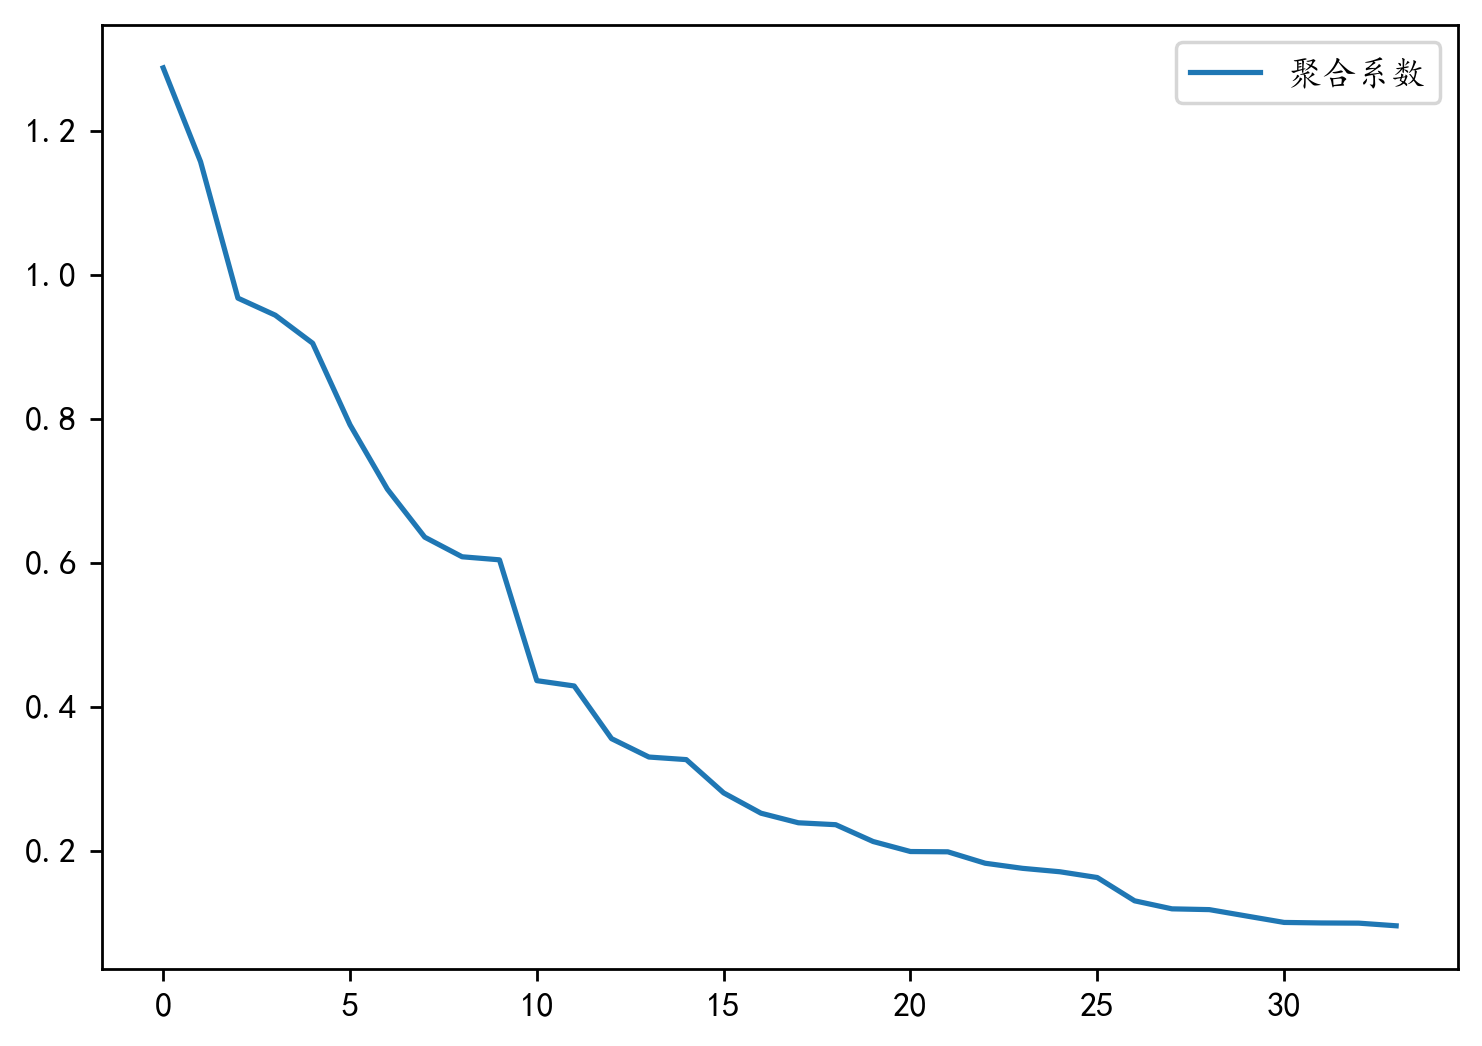

In [315]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.figure(figsize=(7,5),dpi=250)
plt.plot(data4.values,label='聚合系数')
plt.legend()
plt.show()

In [320]:
ddd = pd.read_csv('第二问最终分类结果.csv',encoding='gbk')
ddd

,企业代号,是否违约,信誉评级
0,E124,0,2
1,E125,0,2
2,E126,0,1
3,E127,0,2
4,E128,0,2
...,...,...,...
297,E421,0,3
298,E422,0,3
299,E423,1,4
300,E424,1,4


In [322]:
for i in range(len(ddd)):
    if ddd.loc[i,'信誉评级']==1:
        ddd.loc[i,'评级']='A'
    elif ddd.loc[i,'信誉评级']==2:
        ddd.loc[i,'评级']='B'
    elif ddd.loc[i,'信誉评级']==3:
        ddd.loc[i,'评级']='C'
    elif ddd.loc[i,'信誉评级']==4:
        ddd.loc[i,'评级']='D'

In [324]:
ddd.to_csv('有评级.csv',encoding='gbk')